In [1]:
import numpy as np
import matplotlib.pyplot as plt
from ngsolve import *
from ngsolve.webgui import Draw

In [7]:
import importlib
import sys
from pathlib import Path
import os 
sys.path.append(str(Path(os.getcwd()).parent / "src"))

import active_gel_fem
importlib.reload(active_gel_fem)

import double_fluid_gel_fem
importlib.reload(double_fluid_gel_fem)

import utils 
importlib.reload(utils)

from ngsolve.webgui import Draw

In [96]:
def plot_frame(n_samples, rho, rho2, vx, vy, nx, ny, title, stride=3):
    X = np.linspace(0, 1, n_samples)
    Y = np.linspace(0, 1, n_samples)
    X, Y = np.meshgrid(X, Y)

    # Plot the contour for rho_vals
    fig, axes = plt.subplots(1, 4, figsize=(20, 4))

    im0 = axes[0].pcolor(X, Y, rho, cmap='Greys')
    fig.colorbar(im0, ax=axes[0])

    im1 = axes[1].pcolor(X, Y, rho2, cmap='Greys')
    fig.colorbar(im1, ax=axes[1])
    axes[1].set_title('total actin')

    mag = np.sqrt(vx**2+vy**2)
    im2 = axes[2].contourf(X, Y, mag, levels=100, cmap='Blues')
    axes[2].set_title('v')
    fig.colorbar(im2, ax=axes[2])
    axes[2].quiver(X[::stride, ::stride], Y[::stride, ::stride], 
            (vx/mag)[::stride, ::stride], (vy/mag)[::stride, ::stride], 
            color='orange', 
            width=0.003,     # Increase width to make arrow shafts thicker
            headwidth=4,     # Increase headwidth for wider arrowheads
            headlength=5,    # Increase headlength for longer arrowheads
            headaxislength=7 # Increase headaxislength for more pronounced heads
    ) 

    mag = np.sqrt(nx**2+ny**2)
    im3 = axes[3].contourf(X, Y, mag, levels=100, cmap='Blues')
    axes[3].set_title('nematic order')
    fig.colorbar(im3, ax=axes[3])
    axes[3].quiver(X[::stride, ::stride], Y[::stride, ::stride], 
            (nx/mag)[::stride, ::stride], (ny/mag)[::stride, ::stride], 
            color='orange', 
            width=0.003,     # Increase width to make arrow shafts thicker
            headlength=0,    
            headaxislength=0 
    ) 

    axes[0].set_title(title)
    plt.tight_layout()
    plt.savefig(f"sim_data/{title}.png", dpi=300)
    plt.show()

tanh = lambda arg: (exp(arg) - exp(-arg))/(exp(arg)+exp(-arg)) 
left_edge = 0.5 - 0.06
right_edge = 0.5 + 0.06
left_transition = 0.5 * (tanh((x - left_edge)/0.01))
right_transition = 0.5 * (tanh((right_edge - x)/0.01))

bottom_transition = 0.5 * (tanh((y - 0.1)/0.1))
top_transition = 0.5 * (tanh((0.9 - y)/0.1))
source = 1*(left_transition + right_transition) *(top_transition + bottom_transition)


In [162]:

T = 100
tau = 0.1
chi0 = 0.01
chi1 = 0.1
beta_prod = 1
beta2 = 1
beta1 = beta_prod/beta2
eta = 1 
kappa = 1e-4

k = 1 
k_actin = 0.1
k2 = 1
k4 = 0.1
k5 = 1


sim = double_fluid_gel_fem.UnsaturedMonomerModel(
                    width=1, height=1, maxh=0.03,
                    gamma=eta, eta_1=eta, eta_2=0,
                    k=1, D=1e-4, k_actin=k_actin, k2=k2*source, k4=k4*(1-source), k5=k5,
                    kappa=kappa, beta1 = beta1, beta2 = beta2,   
                    chi0 = chi0,  chi1 = chi1,
                    Qsq = -1 + 2*source) 

sim.density.Set(0.1)
sim._setup_forms(tau)

sim.simulate(
    tend=T,
    tau=tau,
    save_interval=int(1/tau) # save once a second 
)


  3%|▎         | 28/1000 [00:00<00:08, 113.31it/s]

craete bilinearformapplication


100%|██████████| 1000/1000 [00:07<00:00, 138.76it/s]


In [163]:
sim.visualize(animate=False)

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

In [164]:
filename = 'sim_data/test'

n_samples = 50
data = sim.export_to_npy(filename, n_samples=n_samples)

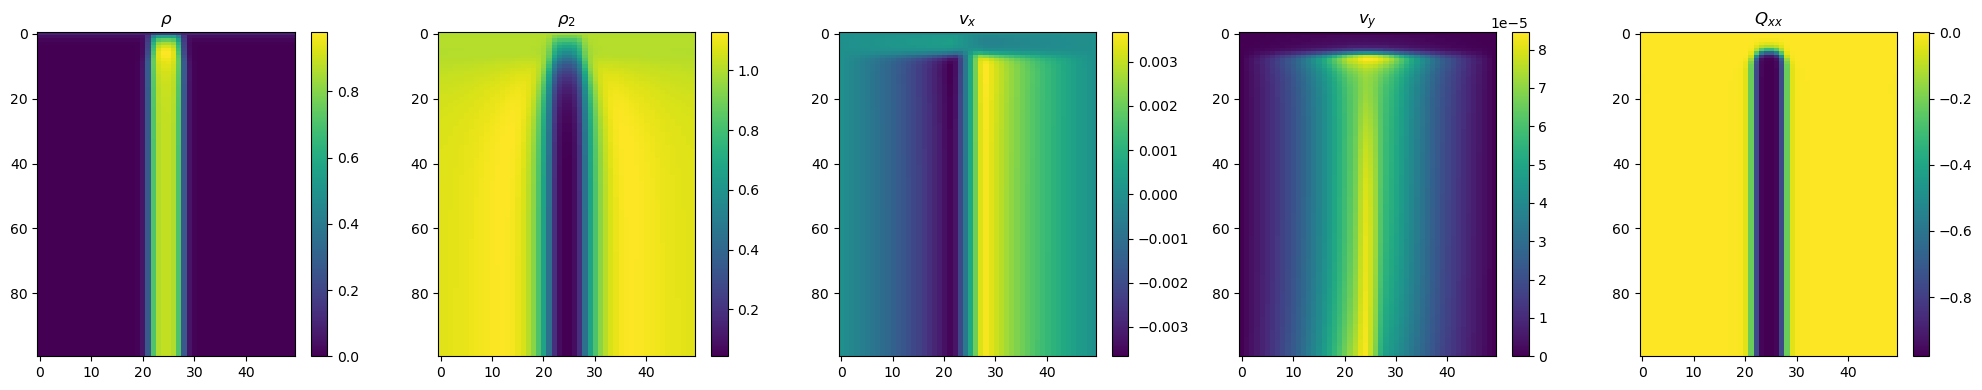

In [165]:
fig, axes = plt.subplots(1, 5, figsize=(20, 4))

fields = [
    (data[:, 24, :, 0], r'$\rho$'),
    (data[:, 24, :, 1], r'$\rho_2$'),
    (data[:, 24, :, 2], r'$v_x$'),
    (data[:, 24, :, 3], r'$v_y$'),
    (data[:, 24, :, -2], r'$Q_{xx}$')
]

for ax, (field, title) in zip(axes, fields):
    im = ax.imshow(field, aspect='auto', interpolation='none')
    fig.colorbar(im, ax=ax)
    ax.set_title(title)

plt.tight_layout()
plt.show()

/var/folders/5n/0rvnm9350db7gk5vdnj3tn6h0000gn/T/ipykernel_86326/3956818753.py:21: RuntimeWarning: invalid value encountered in divide
  (vx/mag)[::stride, ::stride], (vy/mag)[::stride, ::stride],


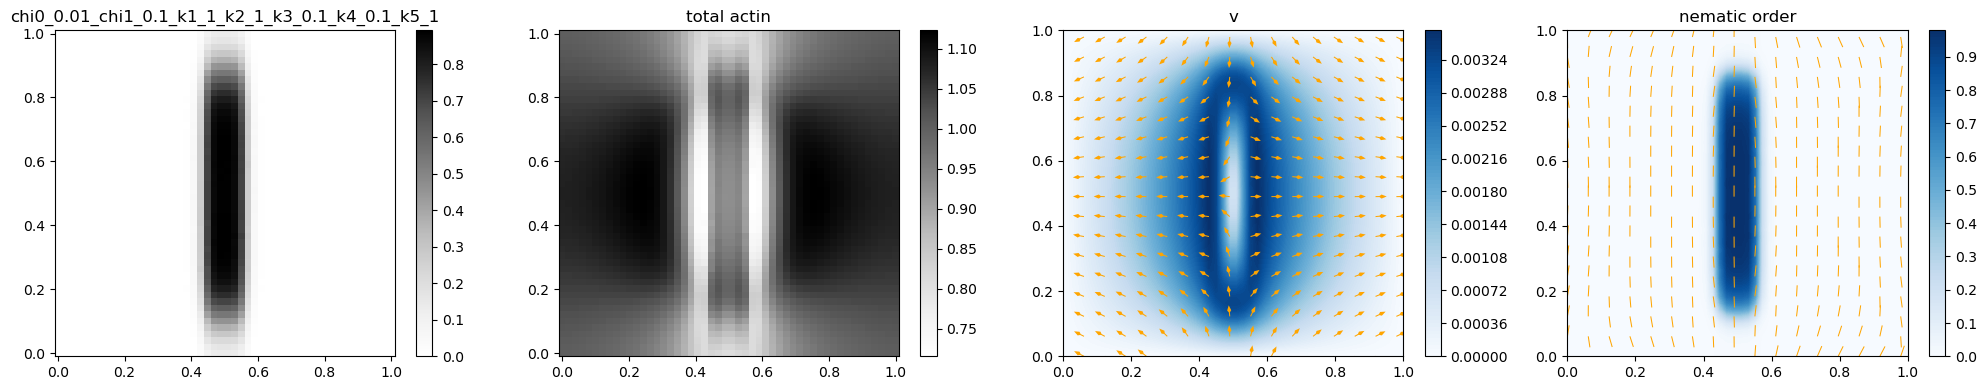

In [166]:
t = -1
rho, rho2, vx, vy, Q, q = np.rollaxis(data[t], -1)
nx, ny = utils.nematic_to_vector(Q, q)

title = 'chi0_{}_chi1_{}_k1_{}_k2_{}_k3_{}_k4_{}_k5_{}'.format(chi0, chi1, k, k2, k_actin, k4, k5)
plot_frame(n_samples, rho, rho2+rho, vx, vy, nx, ny, title=title, stride=3)

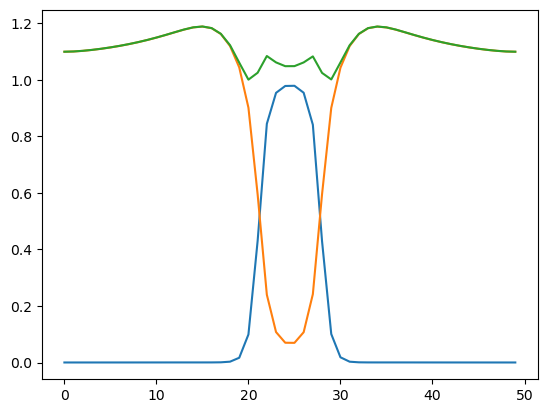

In [155]:
plt.plot(rho[24])
plt.plot(rho2[24])
plt.plot(rho[24] + rho2[24])
plt.show() 

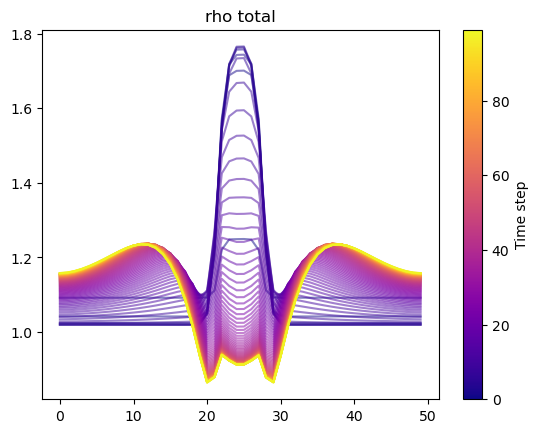

In [156]:
rho2 = data[:, 25,  :, 1] 
rho = data[:, 25,  :, 0]

colors = plt.cm.plasma(np.linspace(0, 1, T))

fig, ax = plt.subplots()
for i in range(T): 
    ax.plot(rho2[i]+rho[i], '-', alpha=0.5, color=colors[i])

sm = plt.cm.ScalarMappable(cmap=plt.cm.plasma, norm=plt.Normalize(vmin=0, vmax=T-1))
sm.set_array([])  # Only needed for older matplotlib versions
cbar = plt.colorbar(sm, ax=ax, label='Time step')

plt.title('rho total')
plt.show()